# Get Strong Earthquakes

To run this tutorial, you to install anaconda or miniconda and create a new environment. <br>
You can do this by running the following commands in terminal. <br>

`conda create -n cophileq python==3.12 pygmt obspy geopandas seaborn ipykernel`

Then activate the environment using <br>

`conda activate cophileq`

In Jupyter you can choose the cophil kernel to run the Jupyter notebooks.

In [1]:
#%% Download the data files if they do not exist
#Check if the files exist and if not download them
import os

if not os.path.exists("S1a_desc_output.csv"):
    print("S1a_desc_output.csv does not exist, downloading...")
    !wget https://zenodo.org/records/15518847/files/S1a_desc_output.csv?download=1  -O S1a_desc_output.csv

if not os.path.exists("S1b_asc_output.csv"):
    print("S1b_asc_output.csv does not exist, downloading...")
    !wget https://zenodo.org/records/15518847/files/S1b_asc_output.csv?download=1  -O S1b_asc_output.csv

In [2]:
#%% Step 0: Import Required Packages
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pygmt

In [3]:
#%% Step 1: Load Input Files

# Load the deformation points
des_df = pd.read_csv("S1a_desc_output.csv")
asc_df = pd.read_csv("S1b_asc_output.csv")

# Select only the columns with "D" at the beginning of the name
des_d_columns = [col for col in des_df.columns if col.startswith("D")]
asc_d_columns = [col for col in asc_df.columns if col.startswith("D")]

# Get element every nth point
n = 50  # Select every 50th point
des_df_sm = des_df.iloc[::n, :]
asc_df_sm = asc_df.iloc[::n, :]

# Region of interest
roi = [120.4, 121.6, 14.3, 15.1] # [min_lon, max_lon, min_lat, max_lat]

# Print the region of interest
print(f"Region of interest: {roi}")

# Select only the LAT, LON and VEL columns
des_vel = des_df_sm[["LON", "LAT", "VEL"]]
asc_vel = asc_df_sm[["LON", "LAT", "VEL"]]

Region of interest: [120.4, 121.6, 14.3, 15.1]


In [4]:
#%% Step 2: Get the region of interest from the ascending and descending data
# Get the region of interest from the descending data
des_region = [
    des_df["LON"].min(),
    des_df["LON"].max(),
    des_df["LAT"].min(),
    des_df["LAT"].max(),
]

# Get the region of interest from the ascending data
asc_region = [
    asc_df["LON"].min(),
    asc_df["LON"].max(),
    asc_df["LAT"].min(),
    asc_df["LAT"].max(),
]

# Combine the regions to get the overall region of interest
region = [
    min(des_region[0], asc_region[0]),
    max(des_region[1], asc_region[1]),
    min(des_region[2], asc_region[2]),
    max(des_region[3], asc_region[3]),
]

# Print the region of interest
print(f"Region of interest: {region}")

Region of interest: [np.float64(120.5484), np.float64(121.4593), np.float64(14.39536), np.float64(15.05815)]


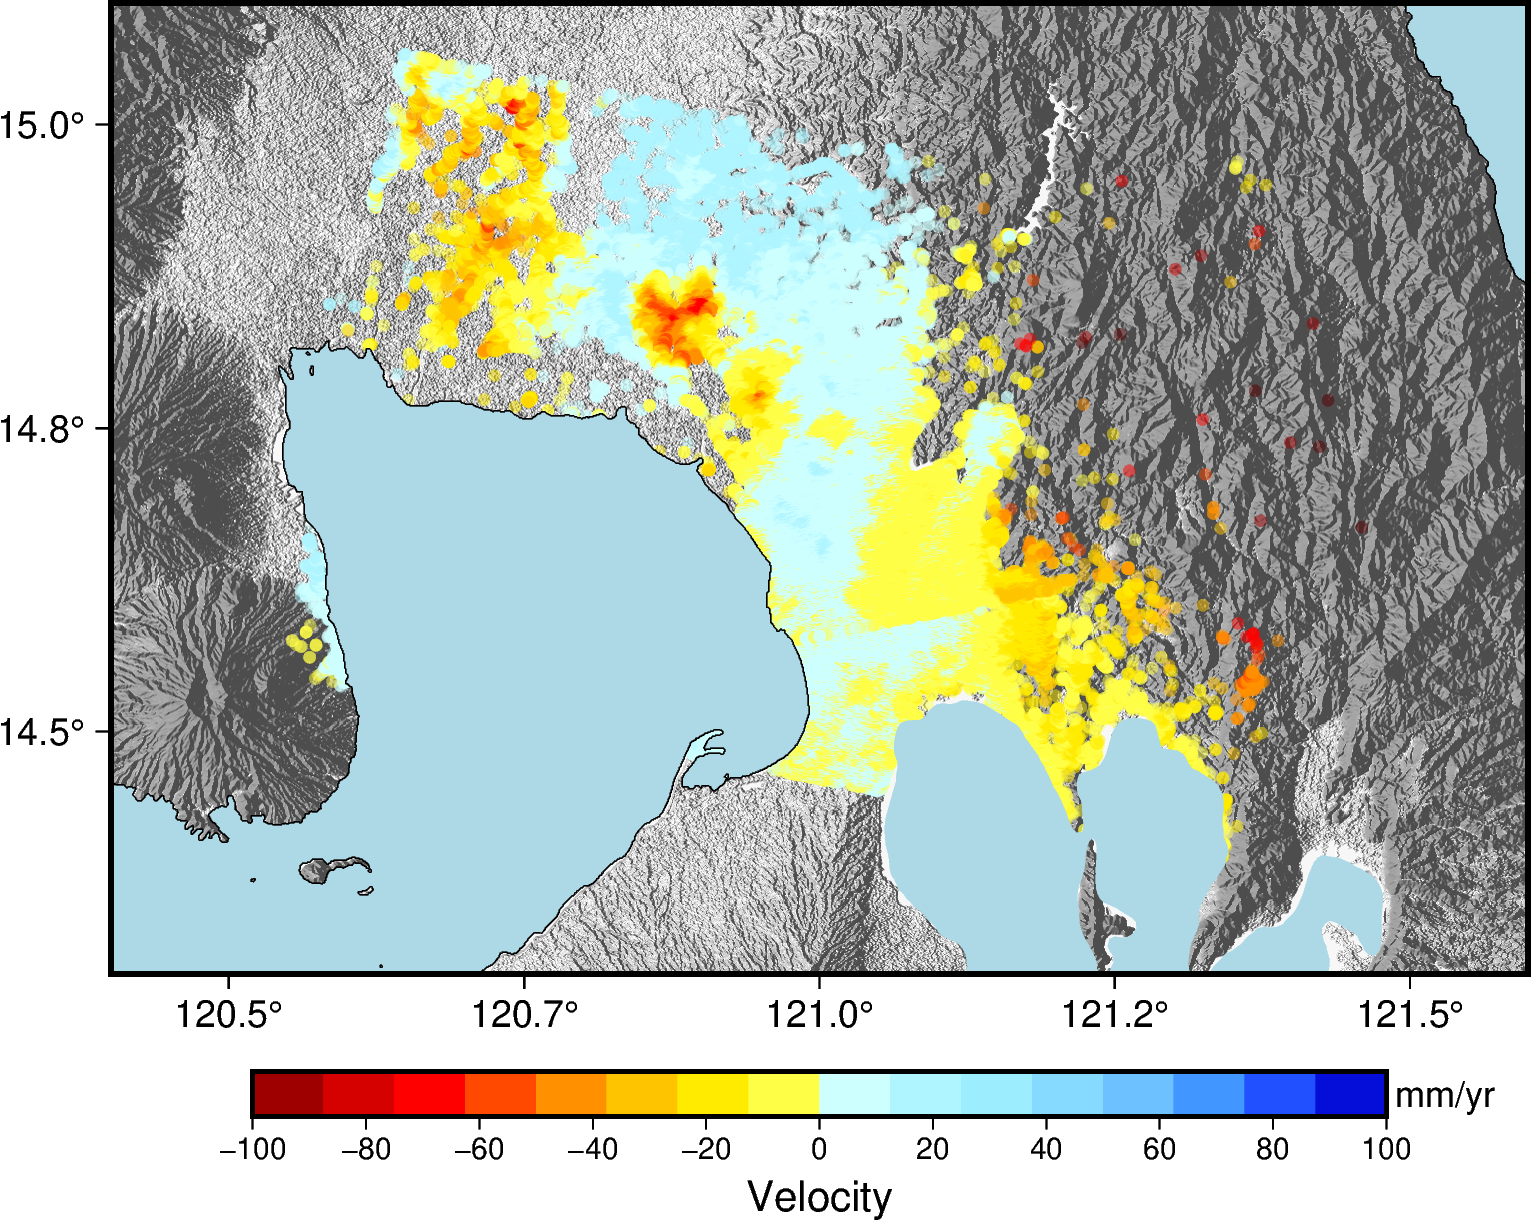

In [5]:
# %%  Step 3: Download the DEM and plot the data using pygmt

# Download the DEM for the region of interest
# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution="03s", region=roi)

# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

# Define the projection
proj = "M12c"  # Mercator projection with a width of 12 cm

fig = pygmt.Figure()
# define figure configuration
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")

pygmt.makecpt(cmap="gray", series=[-1.5, 0.3, 0.01])
fig.grdimage(
    grid=dgrid,
    projection="M12c",
    frame=["lSnWet+t", "xa2", "ya2"],
    cmap=True,
)

# Make CPT using des_vel and asc_vel "VEL" values
pygmt.makecpt(
    cmap="panoply",
#    series=[des_vel["VEL"].min(), des_vel["VEL"].max(), 0.01],
    series=[-100, 100], #[-100, 100, 0.01],
#    continuous=True,
    reverse =True
)

# Plot the descending and ascending velocities
fig.plot(
    data=des_vel,
    style="c0.1c",
    cmap=True,
    transparency=50  # Set transparency for better visibility
)

fig.plot(
    data=asc_vel,
    style="c0.1c",
    cmap=True,
    transparency=50,  # Set transparency for better visibility
)

fig.coast(
    projection=proj,
    resolution="f",
    frame="a",
    water="lightblue",
    lakes="lightblue",
    rivers="1/0.25p,lightblue,solid",
    shorelines="1/0.25p,black",
    dcw="EG+p0.5p,steelblue",
)

# Plot the colorbar
fig.colorbar(frame=["xa20f20+lVelocity", "y+lmm/yr"])

fig.show()


In [6]:
#%% Step 4: Get the dates of the InSAR PSI data to get the overall start and end dates
from datetime import datetime

# Select only the columns with "D" at the beginning of the name
des_d_columns = [col for col in des_df_sm.columns if col.startswith("D")]
asc_d_columns = [col for col in asc_df_sm.columns if col.startswith("D")]

# Get the dates numeric values from the column names
des_dates = [col[1:] for col in des_d_columns]
asc_dates = [col[1:] for col in asc_d_columns]

# Convert the date strings to datetime objects
des_start_date =  min([datetime.strptime(date, "%Y%m%d") for date in des_dates])
des_end_date = max([datetime.strptime(date, "%Y%m%d") for date in des_dates])

asc_start_date = min([datetime.strptime(date, "%Y%m%d") for date in asc_dates])
asc_end_date = max([datetime.strptime(date, "%Y%m%d") for date in asc_dates])

# Get the overall start and end dates
overall_start_date = min(des_start_date, asc_start_date)
overall_end_date = max(des_end_date, asc_end_date)

# Print the overall start and end dates
print(f"Overall start date: {overall_start_date}")
print(f"Overall end date: {overall_end_date}")

Overall start date: 2019-01-02 00:00:00
Overall end date: 2020-12-24 00:00:00


In [7]:
#%% Step 5: Get the earthquakes in the region of interest using obspy
from obspy import read_events
from obspy.clients.fdsn import Client
# Create a client to access the ISC catalog
client = Client()

starttime = overall_start_date
endtime = overall_end_date

cat = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=4,
                        minlatitude=roi[2], maxlatitude=roi[3],
                        minlongitude=roi[0], maxlongitude=roi[1])

print(cat) 

5 Event(s) in Catalog:
2020-02-04T13:56:13.068000Z | +14.477, +121.032 | 4.1  mb
2019-12-02T00:29:01.588000Z | +14.307, +120.658 | 4.0  mb
2019-06-10T23:03:46.116000Z | +14.352, +120.781 | 4.2  mb
2019-04-23T18:02:59.987000Z | +14.911, +120.574 | 4.7  mb
2019-04-22T09:11:11.745000Z | +14.924, +120.497 | 6.1  Mww


In [8]:
#%% Step 6: Arrange the earthquake data into a DataFrame
latitudes = [event.origins[0].latitude for event in cat]
longitudes = [event.origins[0].longitude for event in cat]
magnitudes = [event.magnitudes[0].mag for event in cat]
# Convert depth to km
depth = [event.origins[0].depth / 1000 for event in cat]  
origin_times = [event.origins[0].time for event in cat]

# Print the number of earthquakes found
print(f"Number of earthquakes found: {len(cat)}")

# Create a DataFrame with the earthquake data
import pandas as pd
earthquake_data = {
    "longitude": longitudes,
    "latitude": latitudes,
    "magnitude": magnitudes,
    "depth_km": depth,
    "origin_time": origin_times
}
cat_df = pd.DataFrame(earthquake_data)

# Sort the DataFrame by origin time
cat_df.sort_values(by="origin_time", inplace=True)

# Reset the index of the DataFrame
cat_df.reset_index(drop=True, inplace=True)

# Print the DataFrame
print(cat_df.head())

Number of earthquakes found: 5
   longitude  latitude  magnitude  depth_km                  origin_time
0   120.4972   14.9236        6.1     20.00  2019-04-22T09:11:11.745000Z
1   120.5743   14.9108        4.7     53.44  2019-04-23T18:02:59.987000Z
2   120.7815   14.3520        4.2    185.49  2019-06-10T23:03:46.116000Z
3   120.6584   14.3072        4.0    194.41  2019-12-02T00:29:01.588000Z
4   121.0321   14.4766        4.1    144.37  2020-02-04T13:56:13.068000Z


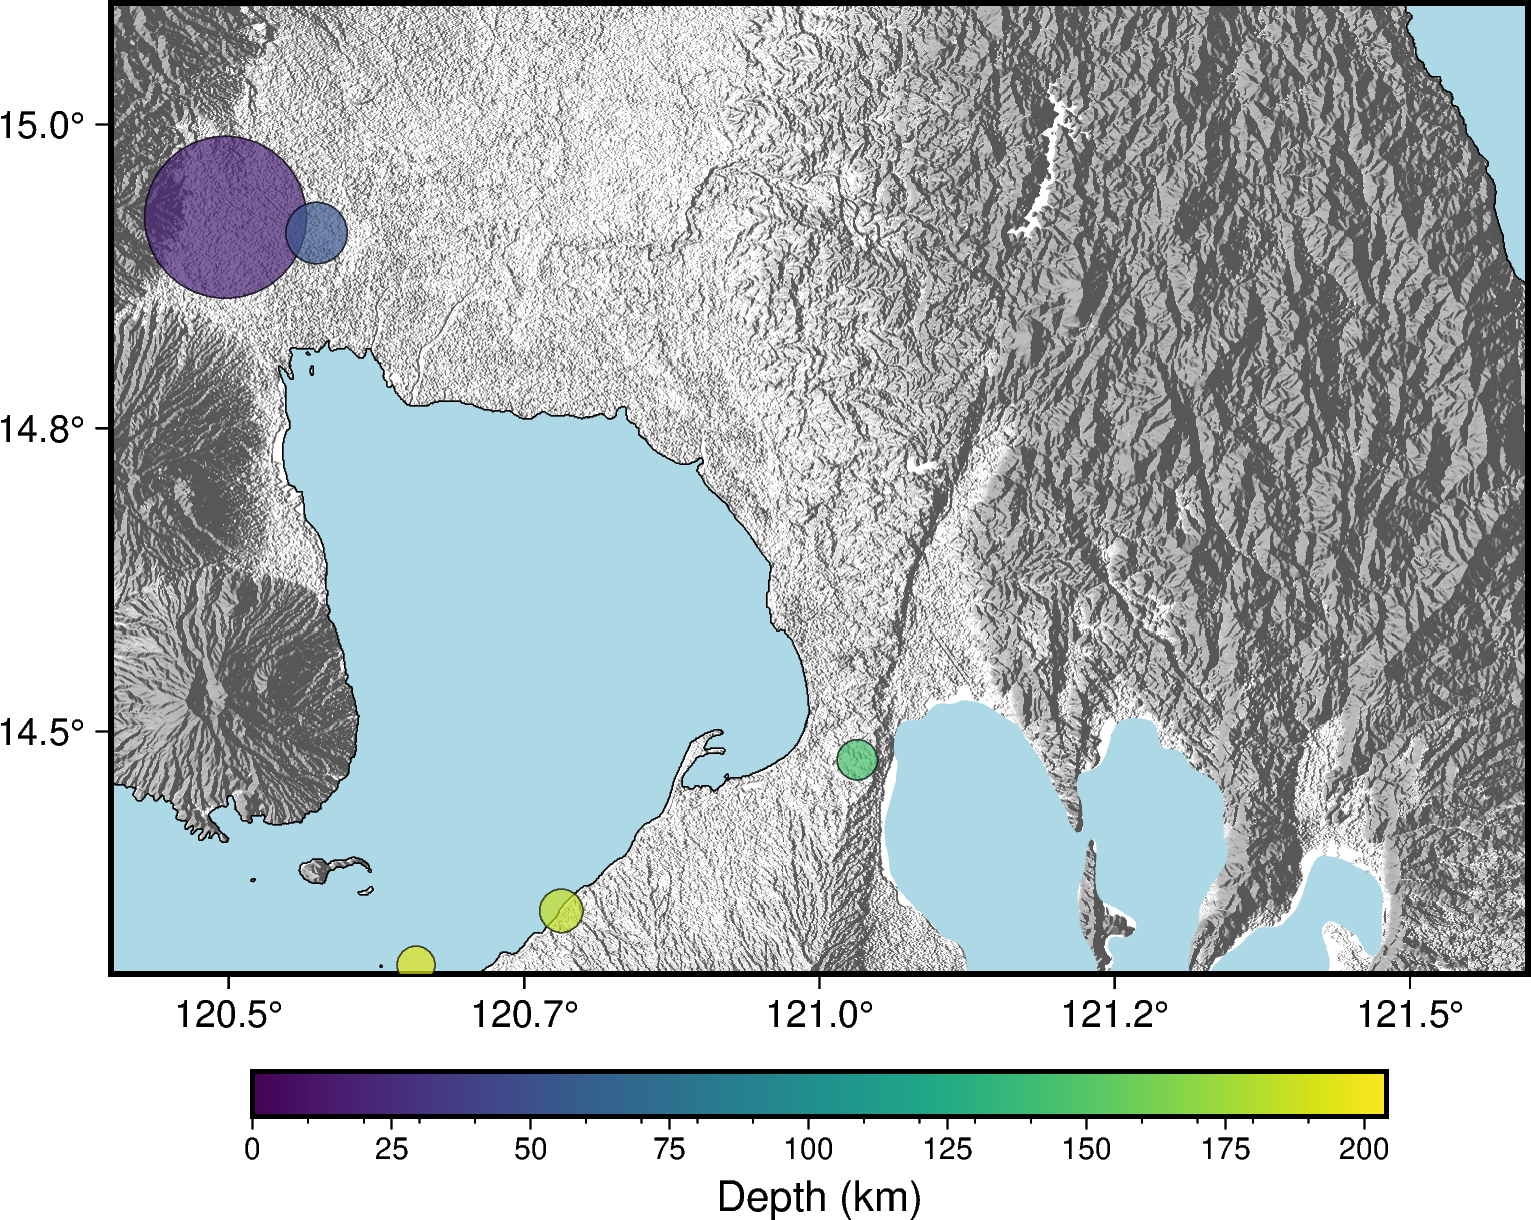

   longitude  latitude  magnitude  depth_km                  origin_time
0   120.4972   14.9236        6.1     20.00  2019-04-22T09:11:11.745000Z
1   120.5743   14.9108        4.7     53.44  2019-04-23T18:02:59.987000Z
2   120.7815   14.3520        4.2    185.49  2019-06-10T23:03:46.116000Z
3   120.6584   14.3072        4.0    194.41  2019-12-02T00:29:01.588000Z
4   121.0321   14.4766        4.1    144.37  2020-02-04T13:56:13.068000Z


In [9]:
#%% Step 7: Plot the earthquakes on a map using pygmt
fig = pygmt.Figure()

# Load sample grid (3 arc-seconds global relief) in target area
grid = pygmt.datasets.load_earth_relief(resolution="03s", region=roi)

# calculate the reflection of a light source projecting from west to east
# (azimuth of 270 degrees) and at a latitude of 30 degrees from the horizon
dgrid = pygmt.grdgradient(grid=grid, radiance=[270, 30])

# Define the projection
proj = "M12c"  # Mercator projection with a width of 12 cm
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")

pygmt.makecpt(cmap="gray", series=[-1.5, 0.1, 0.01])
fig.grdimage(
    grid=dgrid,
    projection="M12c",
    frame=["lSnWet+t", "xa2", "ya2"],
    cmap=True,
)

fig.grdimage(
    grid=dgrid,
    projection=proj,
    frame=["lSnWet+t", "xa2", "ya2"],
    cmap=True,
)

# Add coastlines, rivers, lakes, and borders
fig.coast(
    projection=proj,
    resolution="f",
    frame="a",
    water="lightblue",
    lakes="lightblue",
    rivers="1/0.25p,lightblue,solid",
    shorelines="1/0.25p,black",
    dcw="EG+p0.5p,steelblue",
)

pygmt.makecpt(cmap="viridis", series=[0, cat_df["depth_km"].max()+10, 1],
              continuous=True)

# Plot the earthquakes
fig.plot(
    x=cat_df.longitude,
    y=cat_df.latitude,
    size=0.02 * 2**cat_df.magnitude,
    fill=cat_df.depth_km,
    cmap=True,
    style="cc",
    pen="black",
    transparency=30    
)

fig.colorbar(frame="xa25f+lDepth (km)")

# Show the figure
fig.show()

# Print the DataFrame
print(cat_df.head())